In [ ]:
###################################################Explainer#########################################################
!gdown 1SncS_zVZhjqs3yCokPZFtFZpESUuLnEk -O Explainer_End_To_End_Cnn.md.zip
!unzip -q Explainer_End_To_End_Cnn.md.zip -d /content/explainer
############################################################################################################################

In [ ]:
# =============================
# SECTION 1: IMPORT LIBRARIES
# =============================

import os
import shutil
import kagglehub
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Install additional dependencies
!pip install ipython-autotime --quiet
!pip install gdown --upgrade --quiet
%load_ext autotime



The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.22 s (started: 2025-03-19 20:01:20 +00:00)


In [ ]:
# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

time: 2.77 ms (started: 2025-03-19 20:01:24 +00:00)


In [ ]:
# SECTION 2: Load and Preprocess Dataset
# ======================================


###################################################Explainer#########################################################
# Install gdown if not installed
!pip install gdown --quiet

# Download the file using gdown
!gdown --id 1a3L8dxyiwBG6zf_MzuTegmiUMoOmXIoG -O explainer_transer_learning.zip

# Unzip the downloaded file
!unzip -o explainer_transer_learning.zip

# Verify that the file is extracted
!ls -l explainer_transer_learning.md
############################################################################################################################


# Step 1: Download metadata file (Excel) from Google Drive
DATASET_ID = "10f-OkhFIv1p5IOtY7NBM31n52Ndt7CjS"
DATASET_ZIP = "stanford_cars_with_class_names.zip"
DATASET_EXCEL = "stanford_cars_with_class_names.xlsx"

# Download and unzip dataset metadata
!gdown {DATASET_ID} -O {DATASET_ZIP}
!unzip -q {DATASET_ZIP} -d /content/dataset

# Step 2: Download dataset images from KaggleHub
!mkdir -p /content/dataset
path = kagglehub.dataset_download("jessicali9530/stanford-cars-dataset")
!mv /root/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/* /content/dataset

# Step 3: Load dataset metadata (Excel)
metadata_path = "/content/dataset/" + DATASET_EXCEL
xls = pd.ExcelFile(metadata_path)

# Load train and test datasets
train_df = pd.read_excel(xls, sheet_name="train")
test_df = pd.read_excel(xls, sheet_name="test")

# Step 4: Load annotations from the `.mat` file
annotations_path = "/content/dataset/cars_annos.mat"
metadata = scipy.io.loadmat(annotations_path)
annotations = metadata["annotations"]
class_names = metadata["class_names"]

# Convert class names to a list
class_names_list = [name[0] for name in class_names[0]]

# Step 5: Extract class labels and image paths
def extract_annotations(df):
    annotations = []
    class_names = np.empty(196, dtype=object)
    for _, row in df.iterrows():
        image_path = row["image"]
        class_num = int(row["class"]) - 1
        class_name = row["ture_class_name"]
        class_names[class_num] = class_name
        annotations.append((image_path, class_num))
    return annotations, class_names

# Extract annotations for train and test sets
train_annotations, train_class_names = extract_annotations(train_df)
test_annotations, test_class_names = extract_annotations(test_df)

# Step 6: Function to extract image paths and labels
def get_image_paths_and_labels(df, dataset_type="cars_train"):
    image_paths = []
    labels = []

    for _, row in df.iterrows():
        image_name = row["image"]
        class_num = int(row["class"]) - 1
        image_paths.append(f"/content/dataset/{dataset_type}/{image_name}")
        labels.append(class_num)

    return image_paths, labels

# Extract train and test image paths and labels
train_image_paths, train_labels = get_image_paths_and_labels(train_df, "cars_train")
test_image_paths, test_labels = get_image_paths_and_labels(test_df, "cars_test")

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=196)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=196)

# Print dataset information
print("Dataset Successfully Loaded!")
print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of test images: {len(test_image_paths)}")
print(f"Example training image path: {train_image_paths[0]}")
print(f"Sample class names: {train_class_names[:10]}")


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1a3L8dxyiwBG6zf_MzuTegmiUMoOmXIoG
To: /content/explainer_transer_learning.zip
100% 2.26k/2.26k [00:00<00:00, 9.35MB/s]
Archive:  explainer_transer_learning.zip
  inflating: explainer_transer_learning.md  
-rw-r--r-- 1 root root 5486 Feb 25 20:36 explainer_transer_learning.md
Downloading...
From: https://drive.google.com/uc?id=10f-OkhFIv1p5IOtY7NBM31n52Ndt7CjS
To: /content/stanford_cars_with_class_names.zip
100% 766k/766k [00:00<00:00, 11.9MB/s]


100%|██████████| 1.82G/1.82G [00:10<00:00, 183MB/s]

Extracting files...


Dataset Successfully Loaded!
Number of training images: 8144
Number of test images: 8041
Example training image path: /content/dataset/cars_train/00001.jpg
Sample class names: ['AM General Hummer SUV 2000' 'Acura RL Sedan 2012' 'Acura TL Sedan 2012'
 'Acura TL Type-S 2008' 'Acura TSX Sedan 2012' 'Acura Integra Type R 2001'
 'Acura ZDX Hatchback 2012' 'Aston Martin V8 Vantage Convertible 2012'
 'Aston Martin V8 Vantage Coupe 2012'
 'Aston Martin Virage Convertible 2012']
time: 48.1 s (started: 2025-03-19 20:01:24 +00:00)


🔹 Image: 01559.jpg | Class: Chrysler Town and Country Minivan 2012
   Bounding Box → x1: 45, y1: 77, x2: 592, y2: 479
🔹 Image: 08026.jpg | Class: Audi S4 Sedan 2007
   Bounding Box → x1: 208, y1: 157, x2: 811, y2: 583
🔹 Image: 06056.jpg | Class: Hyundai Elantra Touring Hatchback 2012
   Bounding Box → x1: 58, y1: 73, x2: 365, y2: 246
🔹 Image: 07274.jpg | Class: Jeep Wrangler SUV 2012
   Bounding Box → x1: 9, y1: 42, x2: 632, y2: 456
🔹 Image: 04719.jpg | Class: BMW X5 SUV 2007
   Bounding Box → x1: 66, y1: 48, x2: 609, y2: 438


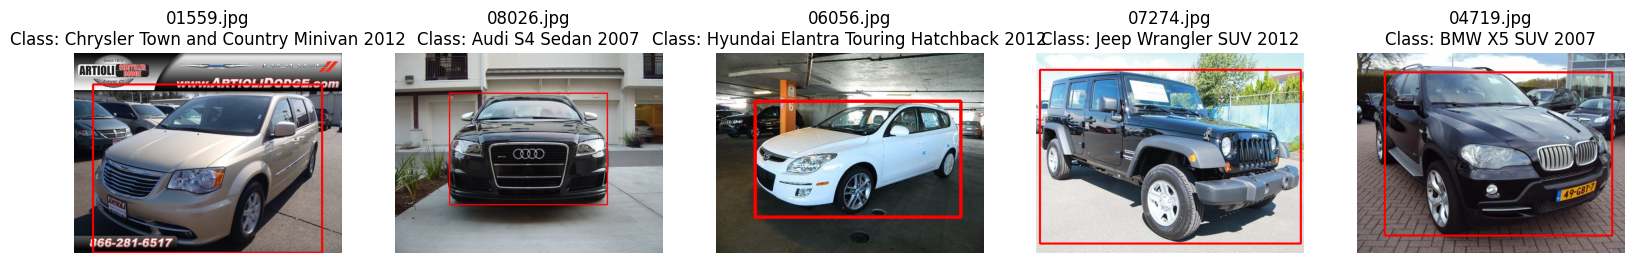

time: 721 ms (started: 2025-03-19 20:02:12 +00:00)


In [ ]:
# SECTION 3: Display Random Images with Annotations
# =====================================================


import cv2
import random


# Select 5 random images
random_samples = random.sample(train_annotations, 5)

def display_images_with_annotations(samples, dataset_path, df):
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))

    if len(samples) < 5:
        print("Not enough images to display.")
        return

    for idx, sample in enumerate(samples):
        if len(sample) < 2:
            print(f"Skipping invalid sample: {sample}")
            continue

        image_name, class_num = sample
        image_path = os.path.join(dataset_path, "cars_train/cars_train", image_name)

        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue

        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load image: {image_path}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Extract bounding box information from DataFrame
        row = df[df['image'] == image_name]
        if not row.empty:
            x1, y1, x2, y2 = int(row.iloc[0]['x1']), int(row.iloc[0]['y1']), int(row.iloc[0]['x2']), int(row.iloc[0]['y2'])
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 3)  # Draw bounding box

            # Display bounding box details
            print(f"🔹 Image: {image_name} | Class: {train_class_names[class_num]}")
            print(f"   Bounding Box → x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")

        # Display image
        title_text = f"{image_name}\nClass: {train_class_names[class_num]}"
        axes[idx].imshow(image)
        axes[idx].set_title(title_text)
        axes[idx].axis("off")

    plt.show()

# Define dataset path
dataset_path = "/content/dataset"
display_images_with_annotations(random_samples, dataset_path, train_df)


Image: 03068.jpg | Class #128 → Honda Accord Coupe 2012
Image: 05364.jpg | Class #105 → Fisker Karma Sedan 2012
Image: 05938.jpg | Class #132 → Hyundai Tucson SUV 2012
Image: 01613.jpg | Class #72 → Chevrolet Monte Carlo Coupe 2007
Image: 05173.jpg | Class #63 → Chevrolet Sonic Sedan 2012


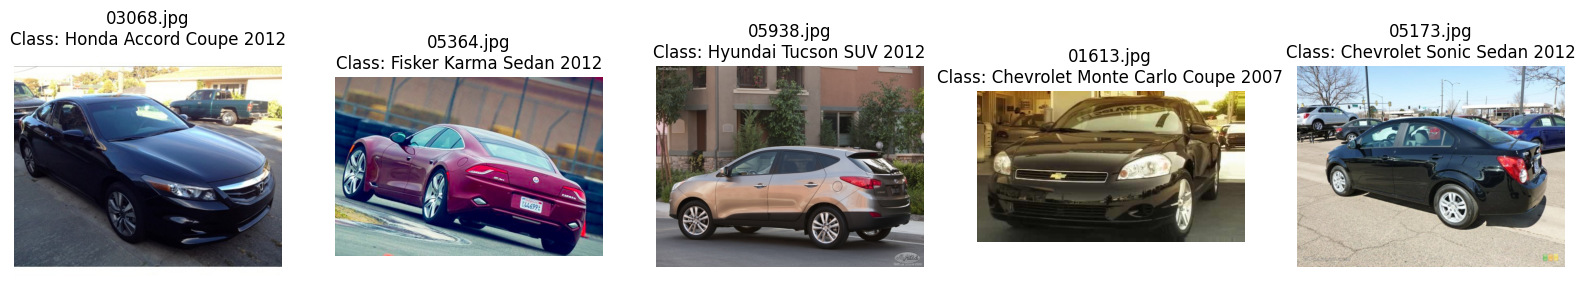

time: 1.7 s (started: 2025-03-19 20:02:13 +00:00)


In [ ]:

# Load the test dataset from Excel
metadata_path = "/content/dataset/stanford_cars_with_class_names.xlsx"
xls = pd.ExcelFile(metadata_path)
test_df = pd.read_excel(xls, sheet_name="test")

# Fix image names (remove extra quotes if they exist)
test_df["image"] = test_df["image"].astype(str).str.replace("'", "")

# Define dataset path for test images
TEST_IMAGE_PATH = "/content/dataset/cars_test/cars_test/"

# Function to display random test images
def display_random_test_images(df, dataset_path, num_samples=5):
    """
    Displays random test images along with their class names.
    """
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

    # Select random images
    samples = df.sample(n=num_samples, random_state=random.randint(0, 10000))

    for idx, (_, row) in enumerate(samples.iterrows()):
        image_name = row["image"]
        image_path = os.path.join(dataset_path, image_name)

        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue

        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load image: {image_path}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Extract class information
        class_name = row["ture_class_name"]
        class_num = int(row["class"])

        # Print image details
        print(f"Image: {image_name} | Class #{class_num} → {class_name}")

        # Display image
        title_text = f"{image_name}\nClass: {class_name}"
        axes[idx].imshow(image)
        axes[idx].set_title(title_text)
        axes[idx].axis("off")

    plt.show()

# Display random test images
display_random_test_images(test_df, TEST_IMAGE_PATH, num_samples=5)


In [ ]:
from tensorflow.keras.models import Sequential

model1 = Sequential()
model1.add( Conv2D(64, kernel_size=3, padding="same", activation='relu',
           kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0001, l2=0.0001),
           input_shape=(224, 224, 3)))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(3, 3)))
model1.add(Dropout(0.4))


model1.add(Conv2D(filters=128, padding="same", kernel_size=3, activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(3, 3)))
model1.add(Dropout(0.4))

model1.add(Conv2D(filters=64, padding="same", kernel_size=3, activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.4))

model1.add(Conv2D(filters=128, padding="same", kernel_size=3, activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.4))


model1.add(Flatten())
model1.add(Dense(1024, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))

model1.add(Dense(196,activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


time: 4.38 s (started: 2025-03-19 20:02:15 +00:00)


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

model1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy']
)


model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 74, 74, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 74, 74, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │              

 Total params: 5,149,444 (19.64 MB)

 Trainable params: 5,146,628 (19.63 MB)

 Non-trainable params: 2,816 (11.00 KB)

time: 114 ms (started: 2025-03-19 20:02:19 +00:00)


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define dataset paths
TRAIN_IMAGE_PATH = "/content/dataset/cars_train/cars_train/"
TEST_IMAGE_PATH = "/content/dataset/cars_test/cars_test/"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Convert class column to string format (important for ImageDataGenerator)
train_df["class"] = train_df["class"].astype(str)
test_df["class"] = test_df["class"].astype(str)

# Split data into training (80%) and validation (20%)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df["class"], random_state=42)

# Data Augmentation for training set
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Normalization for validation and test sets
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_IMAGE_PATH,
    x_col="image",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=TRAIN_IMAGE_PATH,
    x_col="image",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=TEST_IMAGE_PATH,
    x_col="image",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


print("Data Preprocessing Completed!")


Found 6515 validated image filenames belonging to 196 classes.
Found 1629 validated image filenames belonging to 196 classes.
Found 8041 validated image filenames belonging to 196 classes.
Data Preprocessing Completed!
time: 1.11 s (started: 2025-03-19 20:02:19 +00:00)


In [ ]:
EPOCHS = 25

history = model1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    verbose=1
)

print("Training complete.")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 135s 574ms/step - accuracy: 0.0071 - loss: 6.3237 - val_accuracy: 0.0074 - val_loss: 5.4810
Epoch 2/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 104s 510ms/step - accuracy: 0.0128 - loss: 5.7708 - val_accuracy: 0.0166 - val_loss: 6.1170
Epoch 3/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 101s 495ms/step - accuracy: 0.0191 - loss: 5.5343 - val_accuracy: 0.0172 - val_loss: 5.9619
Epoch 4/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 142s 497ms/step - accuracy: 0.0265 - loss: 5.3055 - val_accuracy: 0.0307 - val_loss: 5.5033
Epoch 5/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 101s 492ms/step - accuracy: 0.0353 - loss: 5.1928 - val_accuracy: 0.0356 - val_loss: 6.3089
Epoch 6/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 103s 506ms/step - accuracy: 0.0415 - loss: 5.0705 - val_accuracy: 0.0264 - val_loss: 5.4783
Epoch 7/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 103s 505ms/step - accuracy: 0.0472 - loss: 4.9140 - val_accuracy: 0.0399 - val_loss: 5.8394
Epoch 8/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 103s 503ms/step - accuracy: 0.0580 -

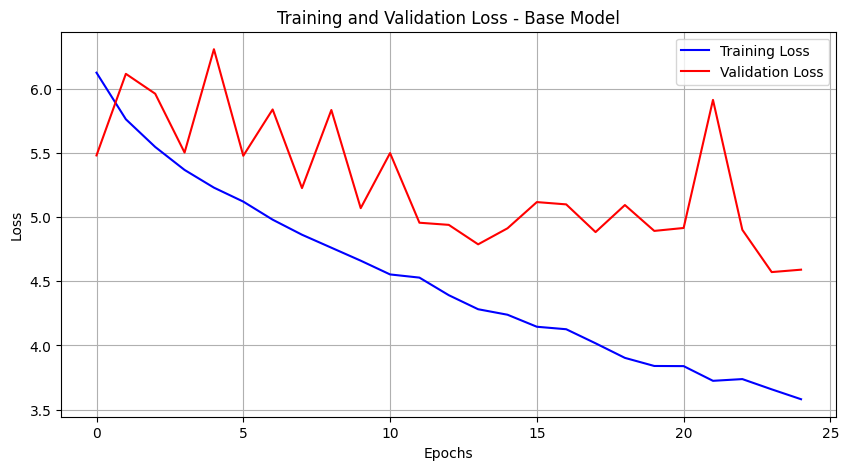

Training with Data Augmentation complete!
Final training accuracy: 0.1942
Final validation accuracy: 0.0939
time: 369 ms (started: 2025-03-19 20:47:05 +00:00)


In [ ]:

# Plot training and validation loss in the same graph
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="red")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss - Base Model")
plt.legend()
plt.grid(True)
plt.show()

# Print final accuracy results
print("Training with Data Augmentation complete!")
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")


Found 5 validated image filenames belonging to 5 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


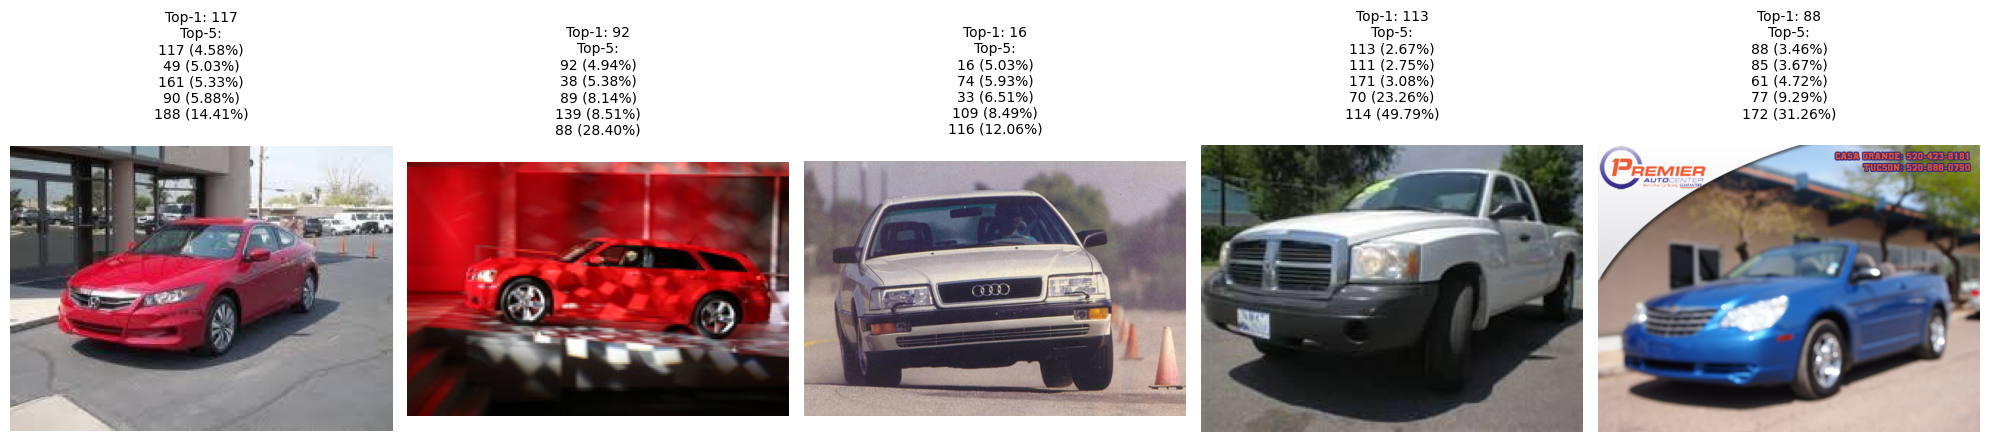

time: 869 ms (started: 2025-03-19 20:50:23 +00:00)


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

# Get class mapping from generator
class_indices = test_generator.class_indices  # Dictionary: {'class_name': index}
index_to_class = {v: k for k, v in class_indices.items()}  # Reverse mapping

# Select 5 random images from the test dataset
random_indices = np.random.choice(len(test_generator.filenames), 5, replace=False)
random_images = [test_generator.filenames[i] for i in random_indices]
true_labels = [test_generator.classes[i] for i in random_indices]

# Get predictions only for the selected 5 images
sample_test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df.iloc[random_indices],
    directory=TEST_IMAGE_PATH,
    x_col="image",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=5,
    class_mode="categorical",
    shuffle=False
)

predictions = model1.predict(sample_test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
top_5_predictions = np.argsort(predictions, axis=1)[:, -5:]
top_5_probs = np.sort(predictions, axis=1)[:, -5:]

# Display images in a row with top-5 predictions above each image
fig, axes = plt.subplots(1, 5, figsize=(20, 6))  # 1 row, 5 columns

for idx, (image_name, true_label) in enumerate(zip(random_images, true_labels)):
    image_path = os.path.join(TEST_IMAGE_PATH, image_name)
    image = Image.open(image_path)

    # Map numerical labels back to class names
    true_class_name = index_to_class[true_label]
    predicted_label = predicted_classes[idx]
    predicted_class_name = index_to_class[predicted_label]

    top_5 = top_5_predictions[idx]
    top_5_confidences = top_5_probs[idx]


    # Formatting top-5 results
    top_5_text = "\n".join([f"{index_to_class[i]} ({top_5_confidences[j]*100:.2f}%)" for j, i in enumerate(top_5[::-1])])

    # Display the image
    axes[idx].imshow(image)
    axes[idx].axis("off")

    # Set title above the image
    axes[idx].set_title(f"Top-1: {predicted_class_name}\nTop-5:\n{top_5_text}", fontsize=10, pad=20)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, top_k_accuracy_score

# Get model predictions on the test dataset
predictions = model1.predict(test_generator, verbose=1)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Get true class labels from the generator
true_classes = test_generator.classes

# Calculate Top-1 Accuracy (Regular Accuracy)
test_accuracy = accuracy_score(true_classes, predicted_classes)

# Calculate Top-5 Accuracy
top_5_accuracy = top_k_accuracy_score(true_classes, predictions, k=5)

# Print evaluation results
print(f" Test Accuracy (Top-1): {test_accuracy:.4f}")
print(f" Test Top-5 Accuracy: {top_5_accuracy:.4f}")


252/252 ━━━━━━━━━━━━━━━━━━━━ 42s 165ms/step
 Test Accuracy (Top-1): 0.1055
 Test Top-5 Accuracy: 0.2839
time: 42.8 s (started: 2025-03-19 20:50:42 +00:00)


In [ ]:
model1.save('car_classification_first_model .h5')
print("Model saved as : car_classification_first_model .h5 ")

Model saved as : car_classification_first_model .h5 
time: 162 ms (started: 2025-03-19 20:51:37 +00:00)


## **Model 2 - More Complex Augmentations**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Input, BatchNormalization, MaxPooling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras import callbacks

time: 519 µs (started: 2025-03-19 21:13:49 +00:00)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense

IMG_SIZE = 224

# Define model
model_2 = Sequential()

# Convolutional layers
model_2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(128, (3, 3), activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(256, (3, 3), activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Dropout(0.25))

# Fully connected layers
model_2.add(Flatten())
model_2.add(Dense(512, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))

# Output layer
model_2.add(Dense(196, activation='softmax'))

# Model summary
model_2.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │      18,874,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 19,367,812 (73.88 MB)

 Trainable params: 19,365,828 (73.87 MB)

 Non-trainable params: 1,984 (7.75 KB)

time: 6.96 s (started: 2025-03-19 21:50:57 +00:00)


In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)]
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer  =  Adam(),
              metrics    =  ['accuracy'])

time: 5.56 ms (started: 2025-03-19 21:51:19 +00:00)


In [ ]:
# Step 3: Load dataset metadata (Excel)
metadata_path = "/content/dataset/" + DATASET_EXCEL
xls = pd.ExcelFile(metadata_path)

# Load train and test datasets
train_df = pd.read_excel(xls, sheet_name="train")
test_df = pd.read_excel(xls, sheet_name="test")

# Step 4: Load annotations from the `.mat` file
annotations_path = "/content/dataset/cars_annos.mat"
metadata = scipy.io.loadmat(annotations_path)
annotations = metadata["annotations"]
class_names = metadata["class_names"]

# Convert class names to a list
class_names_list = [name[0] for name in class_names[0]]

# Step 5: Extract class labels and image paths
def extract_annotations(df):
    annotations = []
    class_names = np.empty(196, dtype=object)
    for _, row in df.iterrows():
        image_path = row["image"]
        class_num = int(row["class"]) - 1
        class_name = row["ture_class_name"]
        class_names[class_num] = class_name
        annotations.append((image_path, class_num))
    return annotations, class_names

# Extract annotations for train and test sets
train_annotations, train_class_names = extract_annotations(train_df)
test_annotations, test_class_names = extract_annotations(test_df)

# Step 6: Function to extract image paths and labels
def get_image_paths_and_labels(df, dataset_type="cars_train"):
    image_paths = []
    labels = []

    for _, row in df.iterrows():
        image_name = row["image"]
        class_num = int(row["class"]) - 1
        image_paths.append(f"/content/dataset/{dataset_type}/{image_name}")
        labels.append(class_num)

    return image_paths, labels

# Extract train and test image paths and labels
train_image_paths, train_labels = get_image_paths_and_labels(train_df, "cars_train")
test_image_paths, test_labels = get_image_paths_and_labels(test_df, "cars_test")

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=196)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=196)

# Print dataset information
print("Dataset Successfully Loaded!")
print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of test images: {len(test_image_paths)}")
print(f"Example training image path: {train_image_paths[0]}")
print(f"Number of test samples in DataFrame: {len(test_df)}")



Dataset Successfully Loaded!
Number of training images: 8144
Number of test images: 8041
Example training image path: /content/dataset/cars_train/00001.jpg
Number of test samples in DataFrame: 8041
time: 2.96 s (started: 2025-03-19 21:51:20 +00:00)


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define dataset paths
TRAIN_IMAGE_PATH = "/content/dataset/cars_train/cars_train/"
TEST_IMAGE_PATH = "/content/dataset/cars_test/cars_test/"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Convert class column to string format (important for ImageDataGenerator)
train_df["class"] = train_df["class"].astype(str)
test_df["class"] = test_df["class"].astype(str)
test_df["image"] = test_df["image"].str.replace("'", "").str.strip()

print(f"Number of test samples in DataFrame: {len(test_df)}")


# Split data into training (80%) and validation (20%)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df["class"], random_state=42)

# Data Augmentation for training set (No Cutout)
train_datagen = ImageDataGenerator(
    rotation_range=25,         # Increased rotation for more variation
    width_shift_range=0.2,     # More horizontal shift
    height_shift_range=0.2,    # More vertical shift
    brightness_range=[0.7, 1.3],  # Random brightness changes
    channel_shift_range=50.0,  # Adjust pixel intensity
    horizontal_flip=True,      # Flip images horizontally
    vertical_flip=True,        # Flip images vertically for more variation
    fill_mode='nearest'        # Fill missing pixels with nearest values
)

# Normalization for validation and test sets
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_IMAGE_PATH,
    x_col="image",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=TRAIN_IMAGE_PATH,
    x_col="image",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=TEST_IMAGE_PATH,
    x_col="image",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

print("Data Preprocessing Completed!")


Number of test samples in DataFrame: 8041
Found 6515 validated image filenames belonging to 196 classes.
Found 1629 validated image filenames belonging to 196 classes.
Found 8041 validated image filenames belonging to 196 classes.
Data Preprocessing Completed!
time: 171 ms (started: 2025-03-19 21:51:24 +00:00)


In [ ]:
EPOCHS = 25  # Number of epochs for training

# Train the model with augmented data
history_aug = model_2.fit(
    train_generator,  # Use the generator directly
    validation_data=val_generator,  # Keep validation unchanged
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),  # Define the steps correctly
    validation_steps=len(val_generator),
    callbacks=[early_stopping],
    verbose=1
)

print("Training with Data Augmentation Completed!")



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 153s 701ms/step - accuracy: 0.0062 - loss: 6.1928 - val_accuracy: 0.0117 - val_loss: 5.8063
Epoch 2/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 144s 708ms/step - accuracy: 0.0089 - loss: 5.9298 - val_accuracy: 0.0135 - val_loss: 5.6288
Epoch 3/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 189s 647ms/step - accuracy: 0.0126 - loss: 5.7441 - val_accuracy: 0.0117 - val_loss: 5.4651
Epoch 4/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 143s 650ms/step - accuracy: 0.0090 - loss: 5.6829 - val_accuracy: 0.0172 - val_loss: 5.2977
Epoch 5/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 138s 631ms/step - accuracy: 0.0164 - loss: 5.5316 - val_accuracy: 0.0215 - val_loss: 5.2648
Epoch 6/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 132s 648ms/step - accuracy: 0.0211 - loss: 5.4450 - val_accuracy: 0.0178 - val_loss: 5.2105
Epoch 7/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 142s 651ms/step - accuracy: 0.0204 - loss: 5.3933 - val_accuracy: 0.0215 - val_loss: 5.2000
Epoch 8/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 129s 634ms/step - accuracy: 0.0181 -

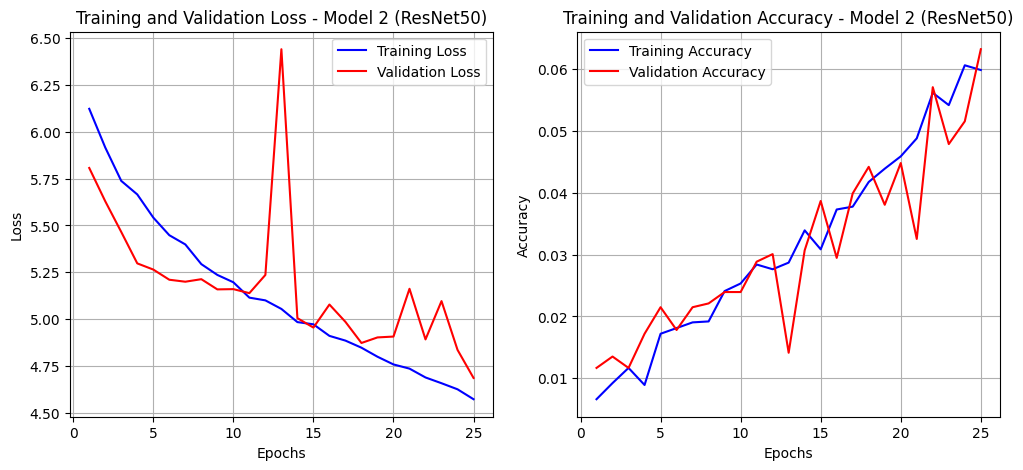

Training with Data Augmentation complete for Model 2 (ResNet50)!
Final training accuracy: 0.0599
Final validation accuracy: 0.0632
time: 519 ms (started: 2025-03-19 22:53:29 +00:00)


In [ ]:
import matplotlib.pyplot as plt

def plot_training_results(history, model_name="Base Model"):
    """
    Plots training and validation loss and accuracy.

    Parameters:
    - history: History object from model.fit()
    - model_name: Name of the model (for title)
    """
    # Extract training history
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    train_acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    epochs = range(1, len(train_loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Training Loss", color="blue")
    plt.plot(epochs, val_loss, label="Validation Loss", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Training and Validation Loss - {model_name}")
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Training Accuracy", color="blue")
    plt.plot(epochs, val_acc, label="Validation Accuracy", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Training and Validation Accuracy - {model_name}")
    plt.legend()
    plt.grid(True)

    plt.show()

    # Print final accuracy results
    print(f"Training with Data Augmentation complete for {model_name}!")
    print(f"Final training accuracy: {train_acc[-1]:.4f}")
    print(f"Final validation accuracy: {val_acc[-1]:.4f}")

# Call function using history_aug from model_2 fitting
plot_training_results(history_aug, model_name="Model 2 (ResNet50)")


Found 5 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


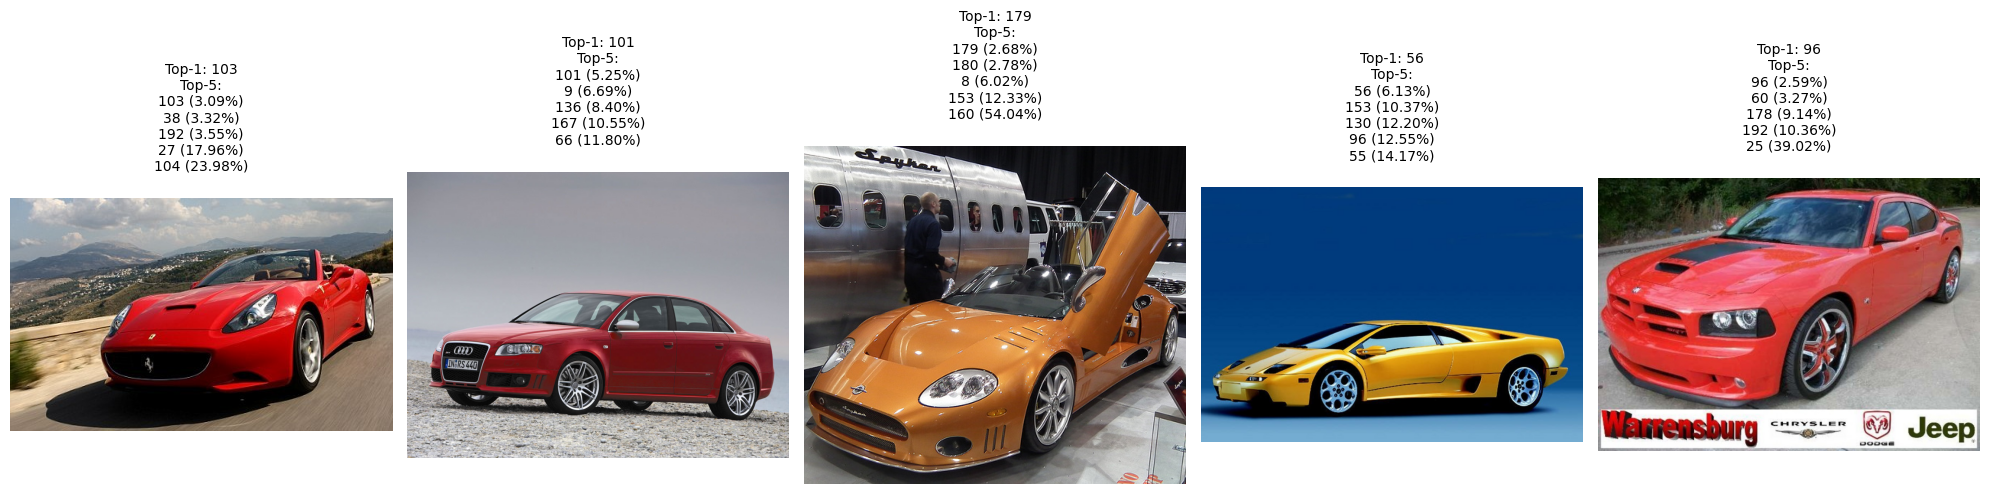

time: 2.12 s (started: 2025-03-19 22:54:47 +00:00)


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

# Get class mapping from generator
class_indices = test_generator.class_indices  # Dictionary: {'class_name': index}
index_to_class = {v: k for k, v in class_indices.items()}  # Reverse mapping

# Select 5 random images from the test dataset
random_indices = np.random.choice(len(test_generator.filenames), 5, replace=False)
random_images = [test_generator.filenames[i] for i in random_indices]
true_labels = [test_generator.classes[i] for i in random_indices]

# Get predictions only for the selected 5 images
sample_test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df.iloc[random_indices].copy(),  # Copy to prevent SettingWithCopyWarning
    directory=TEST_IMAGE_PATH,
    x_col="image",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=5,
    class_mode="categorical",
    shuffle=False
)

predictions = model1.predict(sample_test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
top_5_predictions = np.argsort(predictions, axis=1)[:, -5:]
top_5_probs = np.sort(predictions, axis=1)[:, -5:]

# Display images in a row with top-5 predictions above each image
fig, axes = plt.subplots(1, 5, figsize=(20, 6))  # 1 row, 5 columns

for idx, (image_name, true_label) in enumerate(zip(random_images, true_labels)):
    image_path = os.path.join(TEST_IMAGE_PATH, image_name)

    # Check if image file exists before opening
    if not os.path.exists(image_path):
        print(f"Warning: Image file {image_path} not found.")
        continue

    image = Image.open(image_path)

    # Map numerical labels back to class names
    true_class_name = index_to_class.get(true_label, "Unknown")
    predicted_label = predicted_classes[idx]
    predicted_class_name = index_to_class.get(predicted_label, "Unknown")

    top_5 = top_5_predictions[idx]
    top_5_confidences = top_5_probs[idx]

    # Formatting top-5 results
    top_5_text = "\n".join(
        [f"{index_to_class.get(i, 'Unknown')} ({top_5_confidences[j] * 100:.2f}%)" for j, i in enumerate(top_5[::-1])]
    )

    # Display the image
    axes[idx].imshow(image)
    axes[idx].axis("off")

    # Set title above the image
    axes[idx].set_title(f"Top-1: {predicted_class_name}\nTop-5:\n{top_5_text}", fontsize=10, pad=20)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, top_k_accuracy_score

# Get model predictions on the test dataset
predictions = model_2.predict(test_generator, verbose=1)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Get true class labels from the generator
true_classes = test_generator.classes

# Calculate Top-1 Accuracy (Regular Accuracy)
test_accuracy = accuracy_score(true_classes, predicted_classes)

# Calculate Top-5 Accuracy
top_5_accuracy = top_k_accuracy_score(true_classes, predictions, k=5)

# Print evaluation results
print(f" Test Accuracy (Top-1): {test_accuracy:.4f}")
print(f" Test Top-5 Accuracy: {top_5_accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


252/252 ━━━━━━━━━━━━━━━━━━━━ 46s 179ms/step
 Test Accuracy (Top-1): 0.0609
 Test Top-5 Accuracy: 0.1885
time: 1min 22s (started: 2025-03-19 22:55:26 +00:00)


In [ ]:
model_2.save('car_classification_second_model .h5')
print("Model saved as : car_classification_second_model .h5 ")

Model saved as : car_classification_second_model .h5 
time: 937 ms (started: 2025-03-19 22:56:54 +00:00)


## **Build Model_3 like Resnet50 with simple augmantations**

In [ ]:
# Step 3: Load dataset metadata (Excel)
metadata_path = "/content/dataset/" + DATASET_EXCEL
xls = pd.ExcelFile(metadata_path)

# Load train and test datasets
train_df = pd.read_excel(xls, sheet_name="train")
test_df = pd.read_excel(xls, sheet_name="test")

# Step 4: Load annotations from the `.mat` file
annotations_path = "/content/dataset/cars_annos.mat"
metadata = scipy.io.loadmat(annotations_path)
annotations = metadata["annotations"]
class_names = metadata["class_names"]

# Convert class names to a list
class_names_list = [name[0] for name in class_names[0]]

# Step 5: Extract class labels and image paths
def extract_annotations(df):
    annotations = []
    class_names = np.empty(196, dtype=object)
    for _, row in df.iterrows():
        image_path = row["image"]
        class_num = int(row["class"]) - 1
        class_name = row["ture_class_name"]
        class_names[class_num] = class_name
        annotations.append((image_path, class_num))
    return annotations, class_names

# Extract annotations for train and test sets
train_annotations, train_class_names = extract_annotations(train_df)
test_annotations, test_class_names = extract_annotations(test_df)

# Step 6: Function to extract image paths and labels
def get_image_paths_and_labels(df, dataset_type="cars_train"):
    image_paths = []
    labels = []

    for _, row in df.iterrows():
        image_name = row["image"]
        class_num = int(row["class"]) - 1
        image_paths.append(f"/content/dataset/{dataset_type}/{image_name}")
        labels.append(class_num)

    return image_paths, labels

# Extract train and test image paths and labels
train_image_paths, train_labels = get_image_paths_and_labels(train_df, "cars_train")
test_image_paths, test_labels = get_image_paths_and_labels(test_df, "cars_test")

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=196)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=196)

# Print dataset information
print("Dataset Successfully Loaded!")
print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of test images: {len(test_image_paths)}")
print(f"Example training image path: {train_image_paths[0]}")
print(f"Number of test samples in DataFrame: {len(test_df)}")



Dataset Successfully Loaded!
Number of training images: 8144
Number of test images: 8041
Example training image path: /content/dataset/cars_train/00001.jpg
Number of test samples in DataFrame: 8041
time: 4.63 s (started: 2025-03-19 23:07:01 +00:00)


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define dataset paths
TRAIN_IMAGE_PATH = "/content/dataset/cars_train/cars_train/"
TEST_IMAGE_PATH = "/content/dataset/cars_test/cars_test/"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Convert class column to string format (important for ImageDataGenerator)
train_df["class"] = train_df["class"].astype(str)
test_df["class"] = test_df["class"].astype(str)
test_df["image"] = test_df["image"].str.replace("'", "").str.strip()


# Split data into training (80%) and validation (20%)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df["class"], random_state=42)

# Data Augmentation for training set
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Normalization for validation and test sets
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_IMAGE_PATH,
    x_col="image",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=TRAIN_IMAGE_PATH,
    x_col="image",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=TEST_IMAGE_PATH,
    x_col="image",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


print("Data Preprocessing Completed!")


Found 6515 validated image filenames belonging to 196 classes.
Found 1629 validated image filenames belonging to 196 classes.
Found 8041 validated image filenames belonging to 196 classes.
Data Preprocessing Completed!
time: 143 ms (started: 2025-03-19 23:07:15 +00:00)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Activation,
                                     MaxPooling2D, Add, GlobalAveragePooling2D, Dense, Input)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

IMG_SIZE = (224, 224, 3)
NUM_CLASSES = 196  # Assuming 196 car classes

def identity_block(x, filters):
    """ ResNet Identity Block (No Size Reduction) """
    f1, f2, f3 = filters

    x_skip = x  # Skip Connection

    # First Conv Layer
    x = Conv2D(f1, (1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second Conv Layer (3x3)
    x = Conv2D(f2, (3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Third Conv Layer (1x1)
    x = Conv2D(f3, (1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)

    # Skip Connection Addition
    x = Add()([x, x_skip])
    x = Activation('relu')(x)

    return x

def projection_block(x, filters, strides=(2,2)):
    """ ResNet Projection Block (Size Reduction) """
    f1, f2, f3 = filters

    x_skip = x  # Save input for skip connection

    # First Conv Layer (1x1)
    x = Conv2D(f1, (1,1), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second Conv Layer (3x3)
    x = Conv2D(f2, (3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Third Conv Layer (1x1)
    x = Conv2D(f3, (1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)

    # Adjust Skip Connection
    x_skip = Conv2D(f3, (1,1), strides=strides, padding='same')(x_skip)
    x_skip = BatchNormalization()(x_skip)

    # Merge Skip Connection
    x = Add()([x, x_skip])
    x = Activation('relu')(x)

    return x

def build_resnet_lite(input_shape, num_classes):
    """ Custom ResNet-Like Model (Reduced Depth) """

    inputs = Input(shape=input_shape)

    # Initial Convolution and MaxPooling
    x = Conv2D(64, (7,7), strides=(2,2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

    # ResNet Blocks (Following Updated Structure)
    x = projection_block(x, [64, 64, 256], strides=(1,1))  # Stage 1
    x = identity_block(x, [64, 64, 256])

    x = projection_block(x, [128, 128, 512])  # Stage 2 (Downsampling)
    x = identity_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])

    x = projection_block(x, [256, 256, 1024])  # Stage 3 (Downsampling)
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])

    x = projection_block(x, [512, 512, 2048])  # Stage 4 (Downsampling)
    x = identity_block(x, [512, 512, 2048])
    x = identity_block(x, [512, 512, 2048])

    # Global Average Pooling & Fully Connected Layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create Model
    model = Model(inputs, outputs)

    return model

# Create the model
model_3 = build_resnet_lite(IMG_SIZE, NUM_CLASSES)

# Compile the model
model_3.compile(optimizer=Adam(learning_rate=0.0001),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

# Model Summary
model_3.summary()


Model: "functional_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_69 (Conv2D)        │ (None, 112, 112, 64)   │          9,472 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_73    │ (None, 112, 112, 64)   │            256 │ conv2d_69[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_49             │ (None, 112, 112, 64)   │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_17          │ (None, 56, 56, 64)     │              0 │ activation_49[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_70 (Conv2D)        │ (None, 56, 56, 64)     │          4,160 │ max_pooling2d_17[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_74    │ (None, 56, 56, 64)     │            256 │ conv2d_70[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_50             │ (None, 56, 56, 64)     │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_71 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ activation_50[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_75    │ (None, 56, 56, 64)     │            256 │ conv2d_71[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_51             │ (None, 56, 56, 64)     │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_72 (Conv2D)        │ (None, 56, 56, 256)    │         16,640 │ activation_51[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_73 (Conv2D)        │ (None, 56, 56, 256)    │         16,640 │ max_pooling2d_17[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_76    │ (None, 56, 56, 256)    │          1,024 │ conv2d_72[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_77    │ (None, 56, 56, 256)    │          1,024 │ conv2d_73[0][0]        │
│ (BatchNormalization) 

 Total params: 23,713,732 (90.46 MB)

 Trainable params: 23,669,060 (90.29 MB)

 Non-trainable params: 44,672 (174.50 KB)

time: 782 ms (started: 2025-03-19 23:09:53 +00:00)


In [ ]:
EPOCHS = 25  # Number of epochs for training

# Train the model with augmented data
history_reslike = model_3.fit(
    train_generator,  # Use the generator directly
    validation_data=val_generator,  # Keep validation unchanged
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),  # Define the steps correctly
    validation_steps=len(val_generator),
    callbacks=[early_stopping],
    verbose=1
)

print("Training with Data Augmentation Completed!")



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 201s 750ms/step - accuracy: 0.0063 - loss: 5.3851 - val_accuracy: 0.0049 - val_loss: 5.3036
Epoch 2/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 135s 660ms/step - accuracy: 0.0118 - loss: 5.2346 - val_accuracy: 0.0129 - val_loss: 5.3914
Epoch 3/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 146s 679ms/step - accuracy: 0.0143 - loss: 5.1725 - val_accuracy: 0.0061 - val_loss: 5.8907
Epoch 4/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 136s 647ms/step - accuracy: 0.0216 - loss: 5.0879 - val_accuracy: 0.0104 - val_loss: 5.4035
Epoch 5/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 139s 632ms/step - accuracy: 0.0312 - loss: 5.0227 - val_accuracy: 0.0098 - val_loss: 5.5842
Epoch 6/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 142s 630ms/step - accuracy: 0.0302 - loss: 4.9474 - val_accuracy: 0.0190 - val_loss: 5.3983
Epoch 7/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 148s 662ms/step - accuracy: 0.0375 - loss: 4.8261 - val_accuracy: 0.0172 - val_loss: 5.1795
Epoch 8/25
204/204 ━━━━━━━━━━━━━━━━━━━━ 140s 655ms/step - accuracy: 0.0486 -

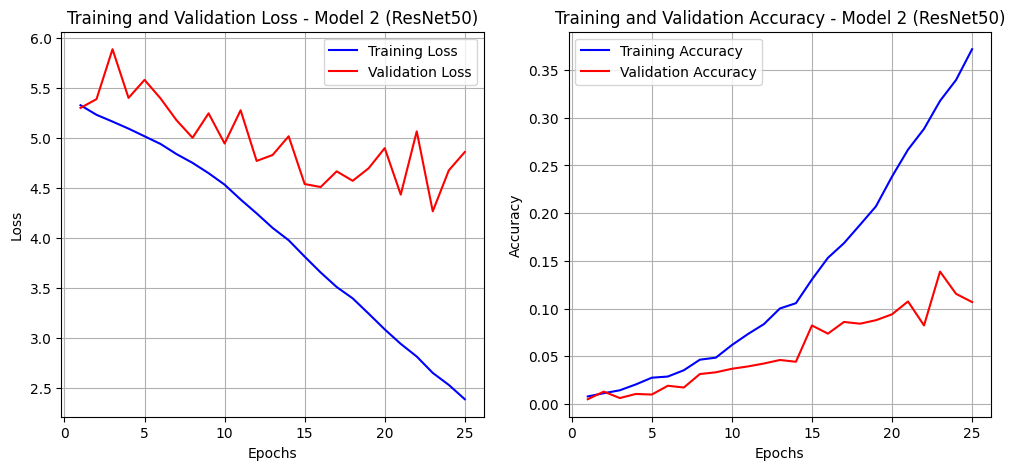

Training with Data Augmentation complete for Model 2 (ResNet50)!
Final training accuracy: 0.3719
Final validation accuracy: 0.1068
time: 477 ms (started: 2025-03-20 00:10:03 +00:00)


In [ ]:
import matplotlib.pyplot as plt

def plot_training_results(history, model_name="ResNet like Model"):
    """
    Plots training and validation loss and accuracy.

    Parameters:
    - history: History object from model.fit()
    - model_name: Name of the model (for title)
    """
    # Extract training history
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    train_acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    epochs = range(1, len(train_loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Training Loss", color="blue")
    plt.plot(epochs, val_loss, label="Validation Loss", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Training and Validation Loss - {model_name}")
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Training Accuracy", color="blue")
    plt.plot(epochs, val_acc, label="Validation Accuracy", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Training and Validation Accuracy - {model_name}")
    plt.legend()
    plt.grid(True)

    plt.show()

    # Print final accuracy results
    print(f"Training with Data Augmentation complete for {model_name}!")
    print(f"Final training accuracy: {train_acc[-1]:.4f}")
    print(f"Final validation accuracy: {val_acc[-1]:.4f}")

# Call function using history_aug from model_2 fitting
plot_training_results(history_reslike, model_name="Model 2 (ResNet50)")


Batch X shape before prediction: (5, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


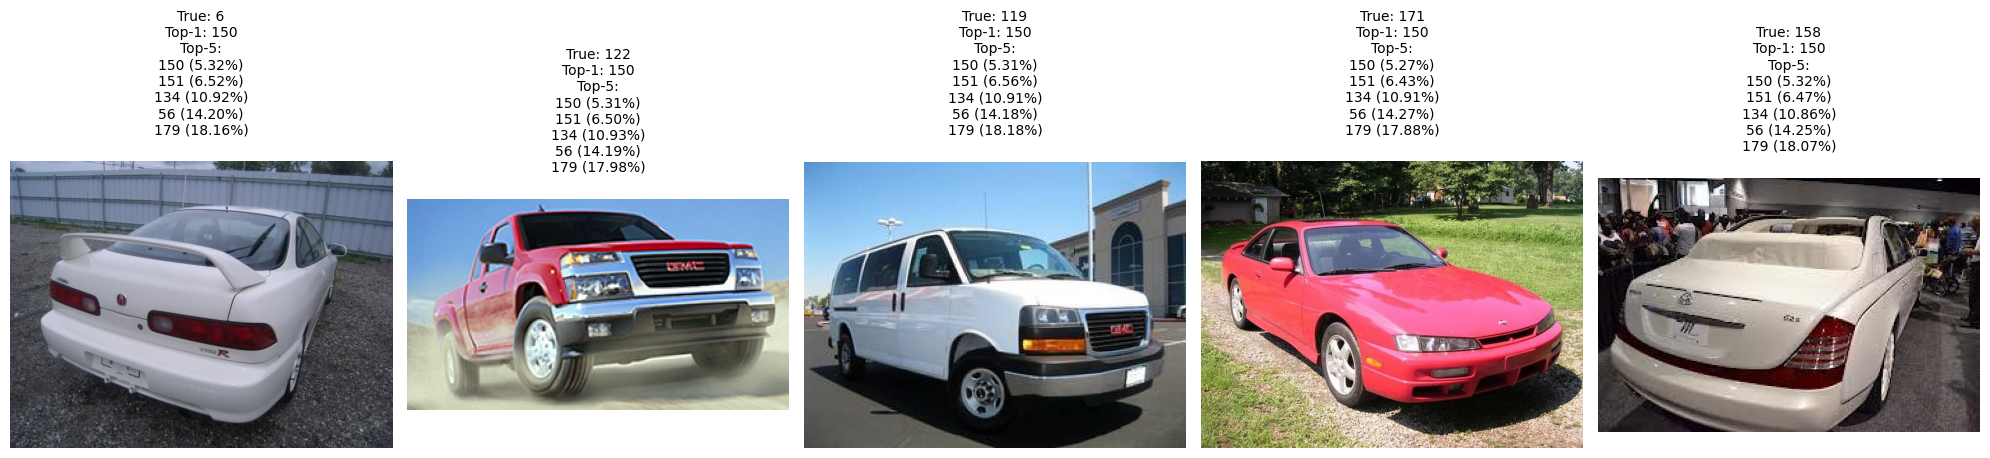

time: 753 ms (started: 2025-03-20 00:16:29 +00:00)


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing import image

# Get class mapping from generator
class_indices = test_generator.class_indices  # Dictionary: {'class_name': index}
index_to_class = {v: k for k, v in class_indices.items()}  # Reverse mapping

# Select 5 random images from the test dataset
random_indices = np.random.choice(len(test_generator.filenames), 5, replace=False)
random_images = [test_generator.filenames[i] for i in random_indices]
true_labels = [test_generator.classes[i] for i in random_indices]

# Function to load and preprocess images manually (Fix grayscale issue)
def ensure_rgb(img_path):
    img = Image.open(img_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')  # Convert grayscale images to RGB
    img = img.resize(IMG_SIZE[:2])  # Resize to (224,224)
    img_array = np.array(img) / 255.0  # Normalize
    return img_array

# Load images manually
batch_x = np.array([ensure_rgb(os.path.join(TEST_IMAGE_PATH, img)) for img in random_images])

# Debug: Print batch shape before prediction
print(f"Batch X shape before prediction: {batch_x.shape}")  # Should be (5, 224, 224, 3)

# Make predictions
predictions = model_3.predict(batch_x, verbose=1)

# Extract Top-5 Predictions
predicted_classes = np.argmax(predictions, axis=1)
top_5_predictions = np.argsort(predictions, axis=1)[:, -5:]
top_5_probs = np.sort(predictions, axis=1)[:, -5:]

# Display images with true label + top-5 predictions
fig, axes = plt.subplots(1, 5, figsize=(20, 6))

for idx, (image_name, true_label) in enumerate(zip(random_images, true_labels)):
    image_path = os.path.join(TEST_IMAGE_PATH, image_name)

    # Check if image file exists before opening
    if not os.path.exists(image_path):
        print(f"Warning: Image file {image_path} not found.")
        continue

    image = Image.open(image_path)

    # Map numerical labels back to class names
    true_class_name = index_to_class.get(true_label, "Unknown")
    predicted_label = predicted_classes[idx]
    predicted_class_name = index_to_class.get(predicted_label, "Unknown")

    top_5 = top_5_predictions[idx]
    top_5_confidences = top_5_probs[idx]

    # Formatting top-5 results
    top_5_text = "\n".join(
        [f"{index_to_class.get(i, 'Unknown')} ({top_5_confidences[j] * 100:.2f}%)" for j, i in enumerate(top_5[::-1])]
    )

    # Display the image
    axes[idx].imshow(image)
    axes[idx].axis("off")

    # Set title above the image (Includes True Label & Top-1 Prediction)
    axes[idx].set_title(f"True: {true_class_name}\nTop-1: {predicted_class_name}\nTop-5:\n{top_5_text}",
                        fontsize=10, pad=20, color="black")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, top_k_accuracy_score

# Get model predictions on the test dataset
predictions = model_3.predict(test_generator, verbose=1)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Get true class labels from the generator
true_classes = test_generator.classes

# Calculate Top-1 Accuracy (Regular Accuracy)
test_accuracy = accuracy_score(true_classes, predicted_classes)

# Calculate Top-5 Accuracy
top_5_accuracy = top_k_accuracy_score(true_classes, predictions, k=5)

# Print evaluation results
print(f" Test Accuracy (Top-1): {test_accuracy:.4f}")
print(f" Test Top-5 Accuracy: {top_5_accuracy:.4f}")


252/252 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step
 Test Accuracy (Top-1): 0.1436
 Test Top-5 Accuracy: 0.3745
time: 1min 22s (started: 2025-03-20 00:16:54 +00:00)


In [ ]:
model_3.save('car_classification_third_model .h5')
print("Model saved as : car_classification_third_model .h5 ")

Model saved as : car_classification_third_model .h5 
time: 5.97 s (started: 2025-03-20 00:18:22 +00:00)
